# Custard cruise autnomy fleet


In [63]:
import pandas as pd
import numpy as np
import requests
import shutil
import os
import gzip
import matplotlib
from pathlib import Path
import re
from tqdm import tqdm
from urllib.request import urlretrieve
import xarray as xr
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from glob import glob
from datetime import datetime
from scipy import interpolate
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from matplotlib_scalebar.scalebar import ScaleBar

In [ ]:
#Wmo of the custard cruise floats
wmo_list = [5906216, 5906217, 5906212, 5906213]

#list of url to the nc sprof
floats_url = []
#Floats from the custard cruise are all sstored on the aoml dac
for wmo in wmo_list:
    temp_url = 'https://data-argo.ifremer.fr/dac/aoml/' + str(wmo) + '/' + str(wmo) + '_Sprof.nc'
    floats_url.append(temp_url)

#Assign the local float directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
floats_dir =  os.path.join(parent_dir, 'Data/Floats')

#Create floats filename
floats_filenames = []
for i in floats_url:
    filename = floats_dir + '/' + i.rsplit('/', 1)[1]
    floats_filenames.append(filename)

In [ ]:
#Download floats data. We do it everytime so we are sure to work with a DAC up to date version. 
#We could check with the synthetic profile index if it is needed to download a update.
for url, filename in zip(floats_url, floats_filenames):
    urlretrieve(url, filename)

# Position of the floats

In [ ]:
position_df = pd.DataFrame({'PROF_NUM' : str(), 'LONGITUDE' : [], 'LATITUDE' : [], 'float' : int()})
for file, wmo in zip(floats_filenames, wmo_list):
    dat = xr.open_dataset(file)
    dat = dat.rename({'CYCLE_NUMBER':'PROF_NUM'}).swap_dims({'N_PROF':'PROF_NUM'})
    temp_df = dat[['LONGITUDE', 'LATITUDE']].to_dataframe().reset_index()
    temp_df['float'] = wmo
    position_df = pd.concat([position_df, temp_df], ignore_index=True)
    dat.close()

In [ ]:
# load the low resolution world map
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

In [ ]:
n = 4
test = np.array(wmo_list) - (min(wmo_list) - 1)
from_list = matplotlib.colors.LinearSegmentedColormap.from_list
cm = from_list(None, plt.cm.Paired(test), n)

In [ ]:
# Create a dictionary to map float values to colors
unique_floats = sorted(position_df['float'].unique())
num_unique_floats = len(unique_floats)
colors = plt.cm.Paired(test)
color_map = {float_val: colors[i] for i, float_val in enumerate(unique_floats)}

# initialize an empty figure and add an axis
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

# plot a basic map of the world
world.plot(
    ax=ax,
    color="lightgray",
    edgecolor="black",
    alpha=0.5
)

# plot the floats trajectories
scatter = ax.scatter(position_df['LONGITUDE'], position_df['LATITUDE'], c=[color_map[val] for val in position_df['float']])

# set the plot title
plt.title("Map of the BGC-Argo floats")
plt.show()

In [ ]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k',
                                        facecolor=cfeature.COLORS['land'])

# Define data's extents I used an arbitrary extent that depicts the region plotted above
min_lon = -100
max_lon = -20
min_lat = -66
max_lat = -25

In [ ]:
bath_directory = parent_dir + '/Data/' + "ne_10m_bathymetry_all/"
def load_bathymetry(zip_file_url):
    """Read zip file from Natural Earth containing bathymetry shapefiles"""
    # Download and extract shapefiles
    import io
    import zipfile

    r = requests.get(zip_file_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(bath_directory)

    # Read shapefiles, sorted by depth
    shp_dict = {}
    files = glob(bath_directory + '*.shp')
    assert len(files) > 0
    files.sort()
    depths = []
    for f in files:
        depth = '-' + f.split('_')[-1].split('.')[0]  # depth from file name
        depths.append(depth)
        bbox = (min_lon - 3, max_lon + 3,min_lat - 1, max_lat + 1)  # (x0, y0, x1, y1)
        nei = shpreader.Reader(f, bbox=bbox)
        shp_dict[depth] = nei
    depths = np.array(depths)[::-1]  # sort from surface to bottom
    return depths, shp_dict

In [ ]:
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib
if __name__ == "__main__":
    # Load data (14.8 MB file)
    depths_str, shp_dict = load_bathymetry(
        'https://naturalearth.s3.amazonaws.com/' +
        '10m_physical/ne_10m_bathymetry_all.zip')

    # Construct a discrete colormap with colors corresponding to each depth
    depths = depths_str.astype(int)
    N = len(depths)
    nudge = 0.01  # shift bin edge slightly to include data
    boundaries = [min(depths)] + sorted(depths+nudge)  # low to high
    norm = matplotlib.colors.BoundaryNorm(boundaries, N)
    blues_cm = matplotlib.colormaps['Blues_r'].resampled(N)
    colors_depths = blues_cm(norm(depths))

    # Set up plot
    # Initialize an empty figure and add an axis
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 1, 1,
                        projection=ccrs.Mercator())

    # Set the map extent based on your latitude and longitude ranges
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Scatter plot
    sc = ax.scatter(position_df['LONGITUDE'], position_df['LATITUDE'], transform=ccrs.PlateCarree(), c = position_df['float'], zorder = 2)
    # Plot lines
    for i in wmo_list:
        plot_df = position_df[position_df['float'] == i]
        ax.plot(plot_df['LONGITUDE'], plot_df['LATITUDE'], c='black', transform.=ccrs.PlateCarree())

    # Iterate and plot feature for each depth level
    for i, depth_str in enumerate(depths_str):
        ax.add_geometries(shp_dict[depth_str].geometries(),
                          crs=ccrs.PlateCarree(),
                          color=colors_depths[i])

    # Add map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(land_50m)
    ax.stock_img()

    # print a grid on it
    gl = ax.gridlines(draw_labels=True,x_inline=False,y_inline=False, crs=ccrs.PlateCarree())

    # Convert vector bathymetries to raster (saves a lot of disk space)
    # while leaving labels as vectors
    ax.set_rasterized(True)

# Glider spotting

In [ ]:
url_links = {
    'Cabot' : 'https://linkedsystems.uk/erddap/files/Public_OG1_Data_001/Cabot_20240528/Cabot_645_R.nc',
    'Nelson' : 'https://linkedsystems.uk/erddap/files/Public_OG1_Data_001/Nelson_20240528/Nelson_646_R.nc',
    'Doombar' : 'https://linkedsystems.uk/erddap/files/Public_OG1_Data_001/Doombar_20240528/Doombar_648_R.nc',
    'Churchill' : 'https://linkedsystems.uk/erddap/files/Public_OG1_Data_001/Churchill_20240528/Churchill_647_R.nc'}

In [47]:
def download_glider_nc(url):
    glider_url = url
    gliders_dir =  os.path.join(parent_dir, 'Data/Gliders')
    glider_filename = gliders_dir + '/' + glider_url.rsplit('/', 1)[1]
    urlretrieve(glider_url, glider_filename)
    return(glider_filename)


In [51]:
def glider_to_pd(nc_path, glider_name):
    dat = xr.open_dataset(nc_path)
    mission_date = pd.to_datetime("2024-05-28 18:57:00")
    dates_nc = dat['TIME']
    filtered_dat = dat.where(dates_nc > mission_date, drop=True)
    df_glid = filtered_dat[['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'CHLA', 'BBP700']].to_dataframe()
    dat.close()
    df_glid['PRES'] = df_glid['PRES'].interpolate()
    df_glid['CHLA'] = df_glid['CHLA'].interpolate()
    df_glid['BBP700'] = df_glid['BBP700'].interpolate()
    df_glid['glider'] = glider_name
    return(df_glid)

In [52]:
cols = ['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'CHLA', 'BBP700']
gliders_df = pd.DataFrame(columns=cols)
for glider, url in url_links.items():
    data = download_glider_nc(url)
    print(f'{glider} data downloaded')
    df = glider_to_pd(data, glider)
    gliders_df = pd.concat([gliders_df if not gliders_df.empty else None, df])

Cabot data downloaded
Nelson data downloaded
Doombar data downloaded
Churchill data downloaded


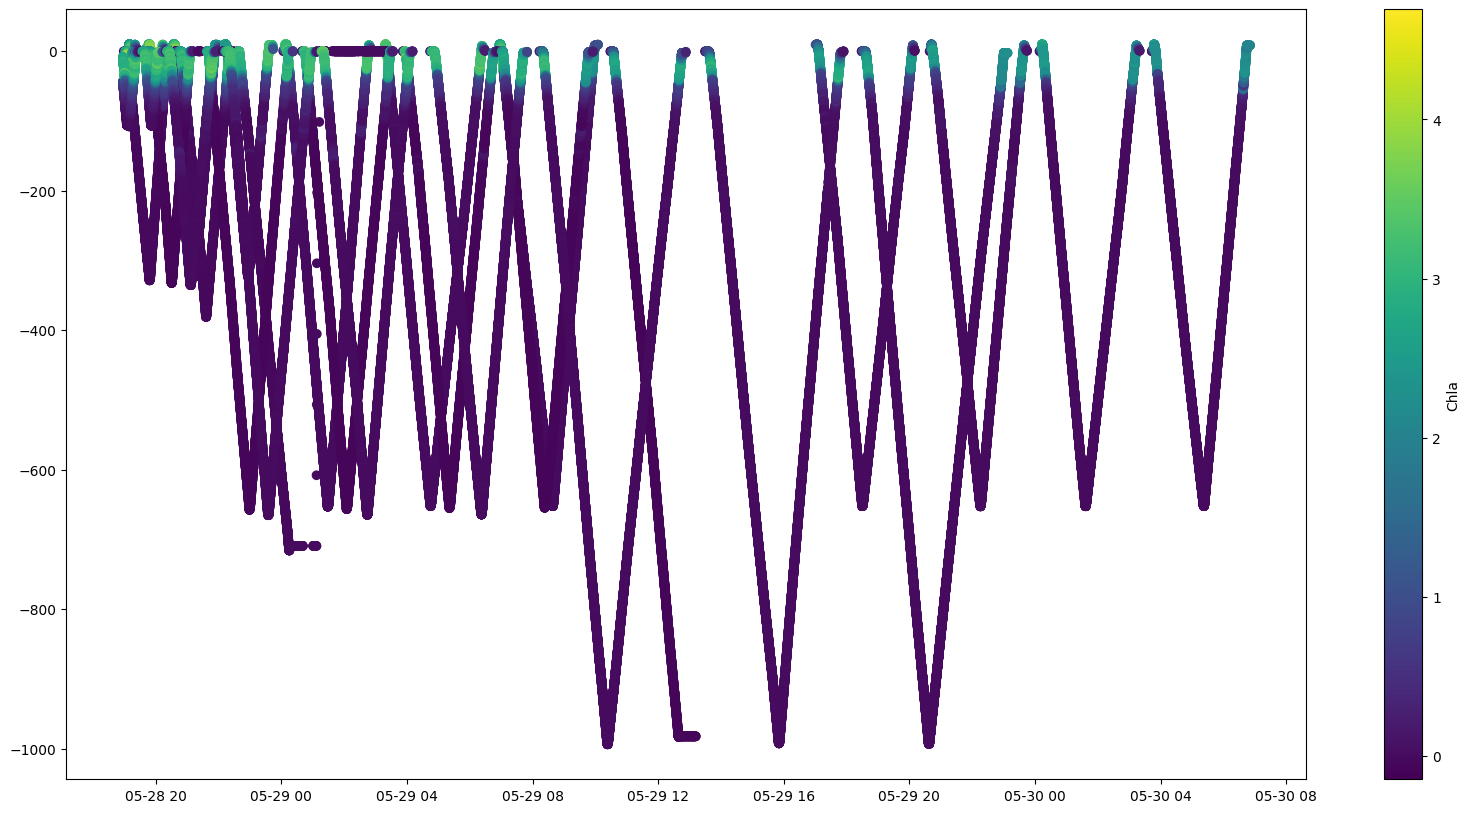

In [53]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)

sc = ax.scatter(gliders_df['TIME'], -gliders_df['PRES'], c = gliders_df['CHLA'])
cbar = plt.colorbar(sc, ax = ax, label='Chla')

plt.show()

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)

sc = ax.scatter(df_glid['TIME'], -df_glid['PRES'], c = df_glid['BBP700'])
cbar = plt.colorbar(sc, ax = ax, label='BBP700')

plt.show()

In [67]:
today = datetime.now().strftime("%Y/%m/%d %H:%M:%S")
today_file = datetime.now().strftime("%Y%m%d_%H%M%S")

In [72]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1,  projection=ccrs.Mercator())
figname = os.path.join(parent_dir, 'Output/Plots/gliders/gliders_transect_' + today_file + '.png')
for glider_name in url_links.keys():
    temp = gliders_df[gliders_df['glider'] == glider_name]
    sc = ax.scatter(temp['LONGITUDE'], temp['LATITUDE'], label = glider_name, transform=ccrs.PlateCarree())

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels

# Add a scale bar
ax.add_artist(ScaleBar(1, location = "lower left"))

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.legend()
plt.title(f'Gliders transects \n Updated : {today}')
plt.savefig(figname)
plt.close()
plt.clf()

<Figure size 640x480 with 0 Axes>

In [ ]:
position_float = position_df[position_df['float'] == 5906213]

min_lon = min(df_tr['LONGITUDE']) - 1
max_lon = max(df_tr['LONGITUDE']) + 0.5
min_lat = min(df_tr['LATITUDE']) - 1
max_lat = max(df_tr['LATITUDE']) + 0.5
# Construct a discrete colormap with colors corresponding to each depth
depths = depths_str.astype(int)
N = len(depths)
nudge = 0.01  # shift bin edge slightly to include data
boundaries = [min(depths)] + sorted(depths+nudge)  # low to high
norm = matplotlib.colors.BoundaryNorm(boundaries, N)
blues_cm = matplotlib.colormaps['Blues_r'].resampled(N)
colors_depths = blues_cm(norm(depths))

# Set up plot
# Initialize an empty figure and add an axis
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1,
                    projection=ccrs.Mercator())

# Set the map extent based on your latitude and longitude ranges
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Scatter plot
sc = ax.scatter(position_float['LONGITUDE'], position_float['LATITUDE'], transform=ccrs.PlateCarree(), c = position_float['PROF_NUM'], zorder = 2)
sc2 = ax.scatter(df_tr['LONGITUDE'], df_tr['LATITUDE'], transform=ccrs.PlateCarree(), c = df_tr['TIME'], zorder = 3)
# Plot lines
ax.plot(position_float['LONGITUDE'], position_float['LATITUDE'], c='black', transform=ccrs.PlateCarree())

# Iterate and plot feature for each depth level
for i, depth_str in enumerate(depths_str):
    ax.add_geometries(shp_dict[depth_str].geometries(),
                        crs=ccrs.PlateCarree(),
                        color=colors_depths[i])

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(land_50m)
ax.stock_img()

# print a grid on it
gl = ax.gridlines(draw_labels=True,x_inline=False,y_inline=False, crs=ccrs.PlateCarree())

# Convert vector bathymetries to raster (saves a lot of disk space)
# while leaving labels as vectors
ax.set_rasterized(True)

## Profile plotting

In [ ]:
dat = xr.open_dataset(floats_filenames[2])
df = dat[['JULD', 'PRES_ADJUSTED', 'TEMP_ADJUSTED', 'PSAL_ADJUSTED', 'CHLA_ADJUSTED', 'BBP700_ADJUSTED', 'DOXY_ADJUSTED']].to_dataframe()
dat.close()

In [ ]:
df = df.dropna()

In [ ]:
last_date = max(df['JULD'])

last_df = df[df['JULD'] == last_date]
early_df = df[df['JULD'] < last_date]

early_df = early_df.reset_index()
alphas = early_df['N_PROF']/(max(early_df['N_PROF']))

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

sc2 = ax.scatter( early_df['TEMP_ADJUSTED'], - (early_df['PRES_ADJUSTED']), alpha = alphas, c = 'grey')
sc = ax.scatter( last_df['TEMP_ADJUSTED'], - (last_df['PRES_ADJUSTED']), c = 'black')

#set the plot color bar
#cbar = plt.colorbar(sc, ax = ax, label='Julian day')
#cbar.set_label('Julian Day', rotation=270, labelpad=15)

# set the plot title
ax.set_title('Float wmo : ' + str(wmo) + "\n Temperature profile : " + last_date.strftime("%Y-%m-%d %H:%M:%S"))
plt.show()

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

sc2 = ax.scatter( early_df['BBP700_ADJUSTED'], - (early_df['PRES_ADJUSTED']), alpha = alphas, c = 'grey')
sc = ax.plot( last_df['BBP700_ADJUSTED'], - (last_df['PRES_ADJUSTED']), c = 'black')

#set the plot color bar
#cbar = plt.colorbar(sc, ax = ax, label='Julian day')
#cbar.set_label('Julian Day', rotation=270, labelpad=15)
ax.set_ylim([-1000,0])
ax.set_xlim([0,0.0015])
# set the plot title
ax.set_title('Float wmo : ' + str(wmo) + "\n BBP 700 profile : " + last_date.strftime("%Y-%m-%d %H:%M:%S"))
plt.show()